**KAGGLE 2025 Pitch by Pitch Dataset**

In [14]:
#gather data
import pandas as pd
mlb_df = pd.read_csv('raw/Data_MLB_2025_StatcastPostseason_PitchByPitch_20251102a.csv')
mlb_df.head()

,game_year,game_date,player_name,pitcher,batter,balls,strikes,inning,inning_topbot,at_bat_number,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
0,2025,2025-09-30,"Ashcraft, Graham",668933,605141,0,0,8,Bot,73,...,10,10,5,Standard,Standard,42.0,0.0,0.041,NaN,NaN
1,2025,2025-09-30,"Ashcraft, Graham",668933,605141,1,0,8,Bot,73,...,10,10,5,Standard,Standard,201.0,0.0,-0.050,NaN,NaN
2,2025,2025-09-30,"Ashcraft, Graham",668933,605141,1,1,8,Bot,73,...,10,10,5,Standard,Standard,23.0,0.0,-0.061,65.0,6.0
3,2025,2025-09-30,"Ashcraft, Graham",668933,605141,1,2,8,Bot,73,...,10,10,5,Standard,Standard,39.0,0.0,0.000,53.1,7.2
4,2025,2025-09-30,"Ashcraft, Graham",668933,605141,1,2,8,Bot,73,...,10,10,5,Standard,Standard,201.0,0.0,0.043,NaN,NaN


In [3]:
print(mlb_df.columns)
print("Number of pitches thrown: ", len(mlb_df))

Index(['game_year', 'game_date', 'player_name', 'pitcher', 'batter', 'balls',
       'strikes', 'inning', 'inning_topbot', 'at_bat_number', 'pitch_number',
       'events', 'pitch_type', 'pitch_name', 'release_speed', 'release_pos_x',
       'release_pos_z', 'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
       'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'fielder_2.1',
       'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top',
       'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle',
       'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk',
       'fielder_2.2', 'fielder_2.3', 'fielder_3', 'fielder_4', 'fielder_5',
       'fielder_6', 'field

**DATA CLEANING AND DATABASE NORMALIZATION** 

In [4]:
#imports FOR PITCHERS DATAFRAME
import pybaseball
from pybaseball import statcast_batter, pitching_stats, playerid_lookup, playerid_reverse_lookup
import duckdb
from duckdb.typing import *
import matplotlib.pyplot as plt

# #connection function
con = duckdb.connect()

#get pitcher data
def player_lookup_single(id, id_type):
    try:
        # Wrap the id in a list
        df = playerid_reverse_lookup([id], 'mlbam')
        if not df.empty:
            last = df.iloc[0]['name_last']
            first = df.iloc[0]['name_first']
            return f"{last}, {first}"
        else:
            return 0
    except Exception:
        return 0

con.create_function("player_lookup", player_lookup_single, ["BIGINT", "BOOLEAN"], "VARCHAR", null_handling="special")

pitchers = con.sql("""
    SELECT distinct(pitcher) AS pitcher_id,
           player_lookup(pitcher, FALSE) AS full_name,
    CASE
            WHEN pitcher_id = pitcher AND inning_topbot = 'Top' THEN home_team
            WHEN pitcher_id = pitcher AND inning_topbot = 'Bot' THEN away_team
            ELSE 'NO-TEAM'
        END AS team_name
    FROM mlb_df
    GROUP BY full_name, batter, pitcher, inning_topbot, home_team, away_team
    ORDER BY pitcher_id DESC
""").to_df()

print(pitchers)

#save
import os

folder = "cleaned"
base_name = "pitchers.csv"
path = os.path.join(folder, base_name)

os.makedirs(folder, exist_ok=True)

pitchers.to_csv(path, index=False)

print(f"Saved to {path}")




/Users/chucksteffen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/y6/bsdqshxs0s7_lwn4r5z7wtwc0000gn/T/ipykernel_7610/698690288.py:5: DeprecationWarning: `duckdb.typing` is deprecated and will be removed in a future version. Please use `duckdb.sqltypes` instead.
  from duckdb.typing import *


Gathering player lookup table. This may take a moment.
     pitcher_id            full_name team_name
0        813349      early, connelly       BOS
1        808967  yamamoto, yoshinobu       LAD
2        808963         sasaki, roki       LAD
3        801139        tolle, payton       BOS
4        702056       yesavage, trey       TOR
..          ...                  ...       ...
138      502085     robertson, david       PHI
139      500779       quintana, jose       MIL
140      477132     kershaw, clayton       LAD
141      458677       wilson, justin       BOS
142      453286        scherzer, max       TOR

[143 rows x 3 columns]
Saved to cleaned/pitchers.csv


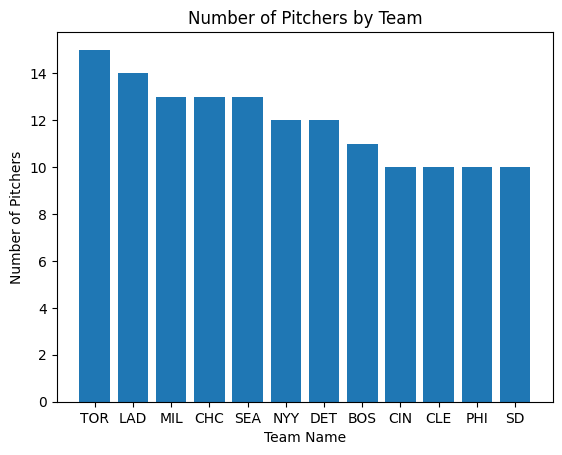

In [5]:
#how many pitchers on each team
pitchers_by_team = con.sql("""
        SELECT team_name, count(team_name) as num_team
        FROM pitchers
        GROUP BY team_name
        ORDER by num_team DESC
        """).to_df()

plt.bar(pitchers_by_team['team_name'], pitchers_by_team['num_team'])
plt.xlabel('Team Name')
plt.ylabel('Number of Pitchers')
plt.title('Number of Pitchers by Team')
plt.show()

In [6]:
#BATTERS dataframe

batters = con.sql("""
    SELECT distinct(batter) AS batter_id,
           player_lookup(batter, FALSE) AS full_name,
    CASE
            WHEN inning_topbot = 'Top' THEN away_team
            WHEN inning_topbot = 'Bot' THEN home_team
            END AS team_name
    FROM mlb_df
    GROUP BY full_name, batter, pitcher, inning_topbot, home_team, away_team
    ORDER BY batter_id DESC
""").to_df()
print(batters)

folder = "cleaned"
base_name = "batters.csv"
path = os.path.join(folder, base_name)

os.makedirs(folder, exist_ok=True)

batters.to_csv(path, index=False)

print(f"Saved to {path}")

     batter_id           full_name team_name
0       807799   yoshida, masataka       BOS
1       807713          shaw, matt       CHC
2       805249          kemp, otto       PHI
3       800050     delauter, chase       CLE
4       702332       durbin, caleb       MIL
..         ...                 ...       ...
150     519317  stanton, giancarlo       NYY
151     518692    freeman, freddie       LAD
152     502671   goldschmidt, paul       NYY
153     500743       rojas, miguel       LAD
154     457759      turner, justin       CHC

[155 rows x 3 columns]
Saved to cleaned/batters.csv


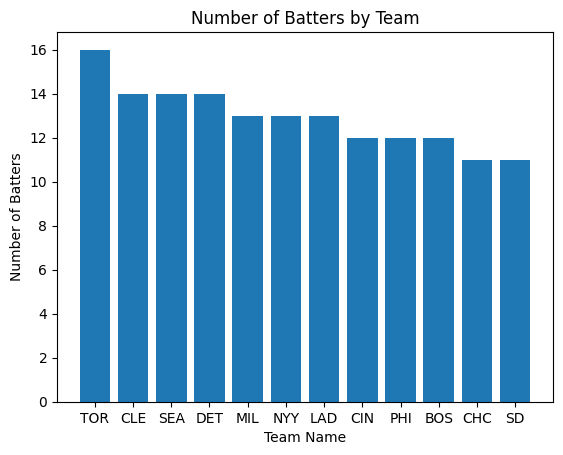

In [7]:
#how many batters on each team
batters_by_team = con.sql("""
        SELECT team_name, count(team_name) as num_team
        FROM batters
        GROUP BY team_name
        ORDER by num_team DESC
        """).to_df()

plt.bar(batters_by_team['team_name'], batters_by_team['num_team'])
plt.xlabel('Team Name')
plt.ylabel('Number of Batters')
plt.title('Number of Batters by Team')
plt.show()

In [8]:
#GAME DATAFRAME
games = con.sql("""
    SELECT distinct(game_pk) AS game_id,
    CASE
        WHEN game_type = 'W' THEN 'World Series'
        WHEN game_type = 'E' THEN 'Exhibition'
        WHEN game_type = 'S' THEN 'Spring Training'
        WHEN game_type = 'R' THEN 'Regular Season'
        WHEN game_type = 'F' THEN 'Wild Card'
        WHEN game_type = 'D' THEN 'Divisional Series'
        WHEN game_type = 'L' THEN 'League Championship Series'
    END AS game_type, game_date, home_team, away_team
    FROM mlb_df
    ORDER BY game_date
        """).to_df()

print(games)

folder = "cleaned"
base_name = "games.csv"
path = os.path.join(folder, base_name)

os.makedirs(folder, exist_ok=True)

games.to_csv(path, index=False)

print(f"Saved to {path}")


    game_id                   game_type   game_date home_team away_team
0    813072                   Wild Card  2025-09-30       CLE       DET
1    813074                   Wild Card  2025-09-30       NYY       BOS
2    813066                   Wild Card  2025-09-30       CHC        SD
3    813069                   Wild Card  2025-09-30       LAD       CIN
4    813070                   Wild Card  2025-10-01       NYY       BOS
5    813068                   Wild Card  2025-10-01       LAD       CIN
6    813071                   Wild Card  2025-10-01       CLE       DET
7    813064                   Wild Card  2025-10-01       CHC        SD
8    813059                   Wild Card  2025-10-02       CHC        SD
9    813065                   Wild Card  2025-10-02       NYY       BOS
10   813073                   Wild Card  2025-10-02       CLE       DET
11   813058           Divisional Series  2025-10-04       SEA       DET
12   813051           Divisional Series  2025-10-04       PHI   

In [9]:
#CLEANING OF PITCH BY PITCH DATA
pitch_by_pitch_df = mlb_df.drop(['player_name', 'game_year', 'home_team', 'away_team'], axis=1)
pitch_by_pitch_df.columns

folder = "cleaned"
base_name = "pitch_by_pitch.csv"
path = os.path.join(folder, base_name)

os.makedirs(folder, exist_ok=True)

pitch_by_pitch_df.to_csv(path, index=False)

print(f"Saved to {path}")

Saved to cleaned/pitch_by_pitch.csv


In [12]:
#how many pitches were thrown
con.sql("""
    SELECT count(*) as num_pitches
    FROM mlb_df
""")

┌─────────────┐
│ num_pitches │
│    int64    │
├─────────────┤
│       14096 │
└─────────────┘

**Analysis Questions**

1. Batters on by pitch type category
2. Pitchers on batter left/right handed
3. Batters overall info
4. Pitchers overall info
5. Batters hit locations
6. MOMENTUM analysis (this one should be fun)
    - winning percentage
7. Conference Championship Games
8. World Series Championship Games


-- with more time

1. Salary analysis
2. Age analysis
3. Veteran analysis
4. Overall 2025 comparative stats to postseason